# Anatomy of a Training Loop with JAX/Flax

While the details of machine learning projects may vary, the core structure of training a model remains fairly consistent. 

## Defining a dataset

Let’s create some toy data where the target y values are a linear transformation of the `x` values with a bit of random noise added. We’ll use the relationship `y = 2x + 1` with Gaussian noise.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax import linen as nn

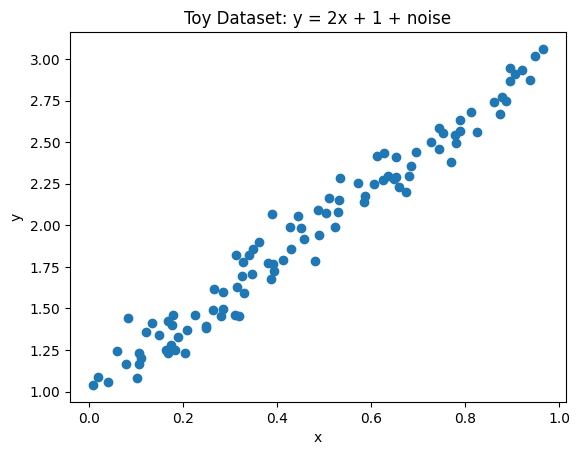

In [2]:
# In JAX, randomness is handled explicitly by passing a random key. 
# We create a key here to seed the random number generator.
rng = jax.random.PRNGKey(42)

# Generate toy data: x values uniformly sampled between 0 and 1.
rng, rng_data, rng_noise = jax.random.split(rng, 3)
x_data = jax.random.uniform(rng_data, shape=(100, 1))

# Add Gaussian noise.
noise = 0.1 * jax.random.normal(rng_noise, shape=(100, 1))

# Define target: y = 2x + 1 + noise.
y_data = 2 * x_data + 1 + noise

# Visualize the noisy linear relationship.
plt.scatter(x_data, y_data)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Toy Dataset: y = 2x + 1 + noise")
plt.show()

## Defining a model

In Flax, we define a model by inheriting from nn.Module. The `@nn.compact` decorator allows us to define layers directly inside the `__call__` method, rather than in the class’s `setup()` method. This is especially useful for simple, sequential models.

In [3]:
class LinearModel(nn.Module):
  @nn.compact
  def __call__(self, x):
    # Applies a single dense (fully connected) layer with 1 output neuron.
    # That is, it computes y = xW + b, where the output has dimension 1.
    return nn.Dense(features=1)(x)

In [4]:
model = LinearModel()

while the Flax API has evolved over time, the core ideas remain stable: 
- defining model layers, 
- initializing parameters, and 
- inferring shapes from inputs.

To initialize the model’s parameters, use the .init method with a `random key` and a `sample input`. 

This allows Flax to infer the input and output shapes. Here, we pass in a dummy input with shape [1, 1]—one example (batch size of 1) with one input feature, matching the shape of our toy data:



In [5]:
rng = jax.random.PRNGKey(42)
variables = model.init(rng, jnp.ones([1, 1]))

In [6]:
jnp.ones([1, 1])

Array([[1.]], dtype=float32)

## Creating a training state


A training state in Flax is a container that packages together everything you need for training: the model’s parameters, the optimizer, and the function used to apply the model. Let’s build one:

In [7]:
import optax
from flax.training import train_state

# Define an optimizer — here we use Adam with a learning rate of 1.0.
# (Note: in most real settings you'd use a smaller learning rate like 1e-3).
tx = optax.adam(learning_rate=1.0)

state = train_state.TrainState.create(
    apply_fn=model.apply, 
    params=variables['params'], 
    tx=tx) # “Tx” is short for transformation

## Defining loss fucntion

In [8]:
def calculate_loss(params, x, y):
  # Run a forward pass of the model to get predictions.
  predictions = model.apply({"params": params}, x)

  # Compute MSE loss.
  return jnp.mean((predictions - y) ** 2)

In [9]:
loss = calculate_loss(variables["params"], x_data, y_data)
print(f"Loss: {loss:.4f}")

Loss: 5.2768


## Defining the training step

The training step performs a **forward pass**, computes the **loss and gradients**, and updates the **model parameters**.

In [10]:
@jax.jit
def train_step(state, x, y):
  def calculate_loss(params):
    predictions = state.apply_fn({"params": params}, x)
    loss = jnp.mean((predictions - y) ** 2)
    return loss, predictions  # Return both loss and preds (aux info).

  (loss, predictions), grads = jax.value_and_grad(calculate_loss, has_aux=True)(
    state.params
  )
  state = state.apply_gradients(grads=grads)
  return state, (loss, predictions)

Without `has_aux=True`, JAX expects the loss function to return a single scalar. Returning anything else (like predictions) will raise an error. By setting `has_aux=True`, you’re telling JAX: “only differentiate with respect to the loss; ignore any extra outputs, like predictions.”

## Defining the training loop

In [11]:
num_epochs = 150  # Number of full passes through the training data.

for epoch in range(num_epochs):
  state, (loss, _) = train_step(state, x_data, y_data)
  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 5.2768
Epoch 10, Loss: 0.9498
Epoch 20, Loss: 0.1091
Epoch 30, Loss: 0.0845
Epoch 40, Loss: 0.0283
Epoch 50, Loss: 0.0258
Epoch 60, Loss: 0.0106
Epoch 70, Loss: 0.0105
Epoch 80, Loss: 0.0106
Epoch 90, Loss: 0.0102
Epoch 100, Loss: 0.0101
Epoch 110, Loss: 0.0100
Epoch 120, Loss: 0.0100
Epoch 130, Loss: 0.0100
Epoch 140, Loss: 0.0100


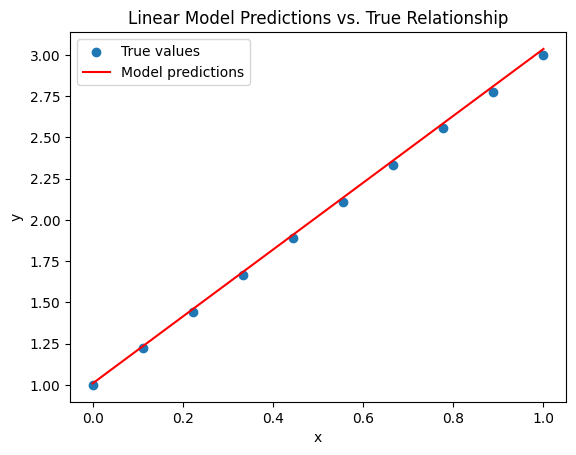

In [12]:
# Generate test data (x values between 0 and 1).
x_test = jnp.linspace(0, 1, 10).reshape(-1, 1)
y_test = 2 * x_test + 1  # Ground truth: linear function without noise.

# Get model predictions.
y_pred = state.apply_fn({"params": state.params}, x_test)

plt.scatter(x_test, y_test, label="True values")
plt.plot(x_test, y_pred, color="red", label="Model predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Linear Model Predictions vs. True Relationship")
plt.show()